In [143]:
import googlemaps
from credentials import google_api_key
from datetime import datetime
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
gmaps = googlemaps.Client(key=google_api_key)
from numpy import s_
import shapely
import numpy as np
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore') 

## Loading street centerline data from Alameda County public data

In [2]:
centerlines = gpd.read_file(("Street_Centerlines/"))
centerlines = centerlines[centerlines.Miles != 0]
# tigerlines = gpd.read_file(("tl_2018_06001_roads/"))
# bikeroutes = gpd.read_file(("bike routes//"))

highways = ['Interstate', 'Ramp', 'Other Freeway or Expressway', ]
highway_types = ['RAMP', 'HW']

In [66]:
def shapely_to_polyline(shapely_coords):
    list_of_coords = list(shapely_coords.coords)
    return [(x[1],x[0]) for x in list_of_coords]

def haversine_distance(coords1, coords2):
    lat1, lon1 = coords1
    lat2, lon2 = coords2
    R = 6371000
    φ1 = np.radians(lat1)
    φ2 = np.radians(lat2)
    Δφ = np.radians(lat2-lat1)
    Δλ = np.radians(lon2-lon1)
    a = np.sin(Δφ/2) * np.sin(Δφ/2) + np.cos(φ1) * np.cos(φ2) * np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c;
    return d

def euclidean_distance(coords):
    return haversine_distance(coords[0], coords[len(coords)-1])

def curvilinear_distance(coords):
    d = 0
    for i in range(len(coords)-1):
        d += haversine_distance(*coords[i:i+2])
    return d

def sinuosity(coords):
    if type(coords) == shapely.geometry.linestring.LineString:
        _coords = shapely_to_polyline(coords)
    else:
        _coords = coords
    try:
        return(curvilinear_distance(_coords) / euclidean_distance(_coords))
    except:
        return None

In [138]:
# add a few columns and preload them. these will be used for edge weights

centerlines = centerlines.assign(elevation = None)
centerlines = centerlines.assign(forward_weight = centerlines.Miles * 1609.34)
centerlines = centerlines.assign(reverse_weight = centerlines.Miles * 1609.34)
centerlines = centerlines.assign(grade = 0)
centerlines = centerlines.set_index('SEGID')

## Load Streets into a NetworkX graph

In [142]:
def add_edge_to_graph(row):
    shapely_coords = row.geometry
    if type(shapely_coords) == shapely.geometry.multilinestring.MultiLineString:
        return
    list_of_coords = list(shapely_coords.coords)
    list_of_coords = [(x[1],x[0]) for x in list_of_coords]
    dG.add_edge(*[list_of_coords[0]] + [list_of_coords[len(list_of_coords) - 1]], 
       name = row.Name, 
       distance = row.Miles * 1609.34, 
       id = row.name,
       weight = row.forward_weight)
    dG.add_edge(*[list_of_coords[len(list_of_coords) - 1]] + [list_of_coords[0]], 
       name = row.Name, 
       distance = row.Miles * 1609.34, 
       id = row.name,
       weight = row.reverse_weight)
    return(shapely_coords)


def get_closest_node(coord, G):
    return(list(G.nodes())[np.argmin([haversine_distance(coord, x) for x in list(G.nodes())])])


def get_path(coord1, coord2, G, weight=None):
    A = get_closest_node(coord1, G)
    B = get_closest_node(coord2, G)
    return nx.shortest_path(G, A, B, weight)


def grade_cost(elevation, coords, distance_window, max_sinuosity):
    cost = 0
    for i in range(len(coords) - 1):
        d = 0
        j = i
        indices = []
        
        segment_elevation_change = elevation[i+1] - elevation[i]
        segment_distance = haversine_distance(coords[i], coords[i+1])
        segment_grade = segment_elevation_change / segment_distance
        segment_sinuosity = 0
        
        while (j < len(coords) - 1) & (d < distance_window):
            d+=haversine_distance(coords[i], coords[j])
            j+=1
            indices.append(j)
        if d > 0:
            segment_sinuosity += sinuosity(coords[i:j])
        if d < distance_window:
            segment_sinuosity += 400/(segment_distance + 100)
        else:
            segment_sinuosity = max_sinuosity
            
        if segment_sinuosity > max_sinuosity:
            segment_sinuosity = max_sinuosity
                                              
        if segment_grade < 0:
            cost  += segment_distance * (1 + 200 * (segment_grade * segment_sinuosity) ** 2)
        else:
            cost  += segment_distance * (1 + 200 * (segment_grade) ** 2)
        
    return(cost)


def update_costs(path, distance_window, max_sinuosity):
    updates = 0
    for i in range(len(path) -1):
        idx = dG.get_edge_data(*path[i:i+2])['id']
        road_class_multiplier = (100 if (centerlines.CLASS[idx] in highways or centerlines.SFEATYP[idx] in highway_types) else 1)

        
        if(centerlines.elevation[dG.get_edge_data(*path[i:i+2])['id']] is None):
            elevation = googlemaps.elevation.elevation(gmaps, shapely_to_polyline(centerlines.geometry[idx]))
            centerlines.elevation[idx] = list(map(lambda x: x['elevation'], elevation))
            
        row = centerlines.loc[idx]            
        row_elevation = row.elevation.copy()
        row_geometry = shapely_to_polyline(row.geometry)
        forward_weight = grade_cost(row_elevation, row_geometry,distance_window, max_sinuosity) * road_class_multiplier
        
        row_elevation.reverse()
        row_geometry.reverse()
        reverse_weight = grade_cost(row_elevation, row_geometry, distance_window, max_sinuosity) * road_class_multiplier
        
        if row.forward_weight != forward_weight:
            updates +=1
            centerlines.loc[idx, 'forward_weight'] = forward_weight
        if row.reverse_weight != reverse_weight:
            updates +=1
            centerlines.loc[idx, 'reverse_weight'] = reverse_weight
        add_edge_to_graph(centerlines.loc[idx])
    return updates
#     centerlines.to_pickle('centerlines.h5')
    


In [140]:
dG = nx.DiGraph()
centerlines.apply(add_edge_to_graph, 1)

SEGID
20201    LINESTRING (-122.019082908173 37.6042845938505...
20202    LINESTRING (-122.05170788583 37.6024152680396,...
21119    LINESTRING (-122.051872488631 37.5908023550251...
21120    LINESTRING (-122.054565486936 37.5903821352304...
26368    LINESTRING (-122.054413480312 37.5997999634119...
                               ...                        
10324    LINESTRING (-122.241075282768 37.7524479231432...
10325    LINESTRING (-122.240027427634 37.7520632049578...
10326    LINESTRING (-122.237561638417 37.7519355589039...
11168    LINESTRING (-122.284001298383 37.7825673991541...
11169    LINESTRING (-122.288192027218 37.7824027136916...
Length: 83944, dtype: object

60TH ST
STANFORD AV
ADELINE ST
ALCATRAZ AV
CLAREMONT AV
GRIZZLY PEAK BL



GRIZZLY PEAK BL
MARIN AV
SHATTUCK AV
WALNUT ST
DELAWARE ST
SHATTUCK AV
ADELINE ST
ASHBY AV
MARTIN LUTHER KING JR WY
ADELINE ST
STANFORD AV
60TH ST


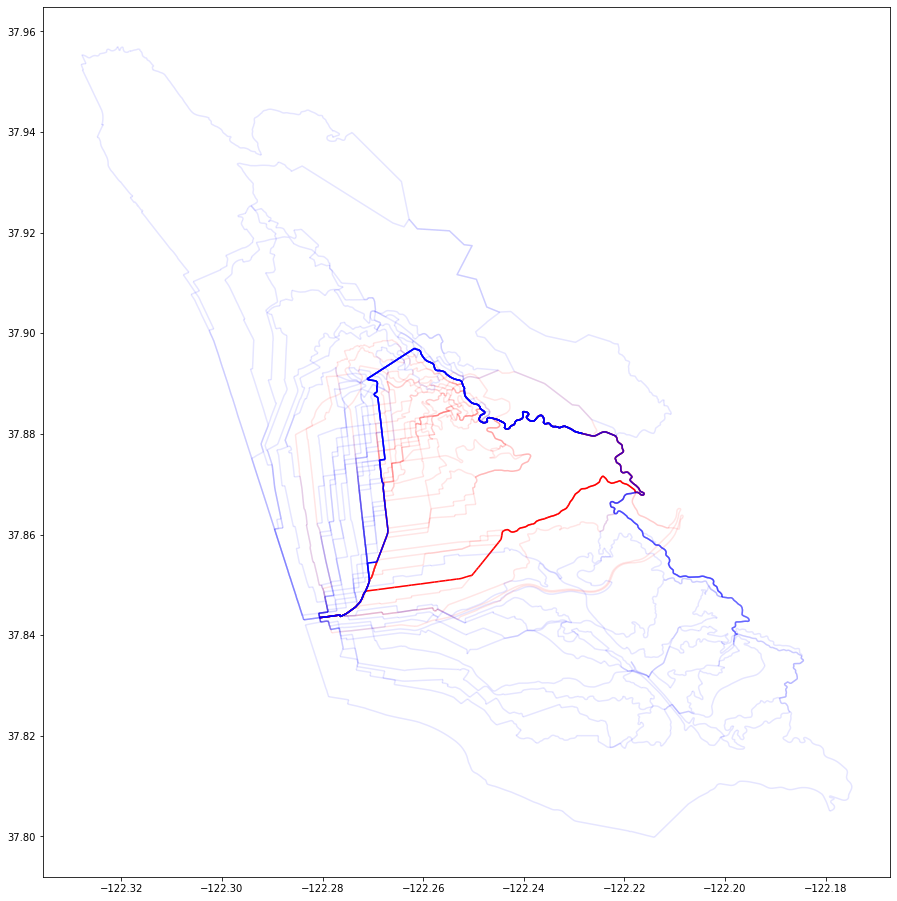

In [141]:
start = (37.843530, -122.280591)
grizzly_peak = (37.881119, -122.231569)
briones = (37.922408, -122.195821)
sibley = (37.847421, -122.199077)

fig, ax = plt.subplots(figsize = (20,16)) 
updates =1 
while updates != 0:
    path = get_path(start, grizzly_peak, dG, weight = 'weight')
    path_nodes = []
    for i in range(len(path) -1):
        path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    centerlines.geometry[path_nodes].plot(ax = ax, alpha=0.1, color = 'red')
    updates = update_costs(path, 1000, 5) 
centerlines.geometry[path_nodes].plot(ax = ax, alpha=1, color = 'red')
last_street_name = ''
for i in range(len(path) -1):
    path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    street_name = dG.get_edge_data(*path[i:i+2])['name']
    if (street_name != last_street_name):
        print(street_name)
        last_street_name = street_name
        
print('\n\n')
        
updates =1 
while updates != 0:
    path = get_path(grizzly_peak, start, dG, weight = 'weight')
    path_nodes = []
    for i in range(len(path) -1):
        path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    centerlines.geometry[path_nodes].plot(ax = ax, alpha=0.1, color = 'blue')
    updates = update_costs(path, 1000, 5) 
centerlines.geometry[path_nodes].plot(ax = ax, alpha=1, color = 'blue')
last_street_name = ''
for i in range(len(path) -1):
    path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    street_name = dG.get_edge_data(*path[i:i+2])['name']
    if (street_name != last_street_name):
        print(street_name)
        last_street_name = street_name
        
plt.show()
